In [1]:
# Standard library imports
import os
import random
import shutil
import glob

# Third-party libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K



2025-01-16 13:37:31.987992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-16 13:37:31.988058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-16 13:37:31.989378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 13:37:31.996335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Training and validation generators
patch_dir = r'dataset_'

# Training image generator
train_image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Training mask generator
train_mask_generator = ImageDataGenerator().flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(256, 256),
    batch_size= 32,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Combine training generators
train_generator = zip(train_image_generator, train_mask_generator)

# Validation image generator
val_image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Validation mask generator
val_mask_generator = ImageDataGenerator().flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Combine validation generators
val_generator = zip(val_image_generator, val_mask_generator)

Found 133623 images belonging to 1 classes.
Found 133623 images belonging to 1 classes.
Found 5445 images belonging to 1 classes.
Found 5445 images belonging to 1 classes.


(256, 256, 1)


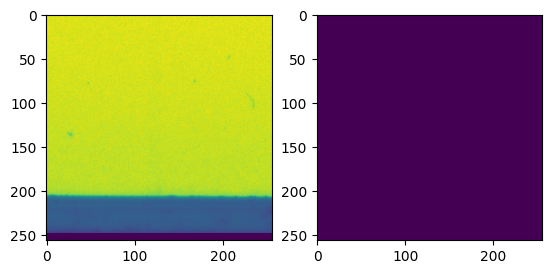

In [3]:
sample = val_generator.__next__()
fig, ax = plt.subplots(1, 2)
print(sample[0][0].shape)
ax[0].imshow(sample[0][0])
ax[1].imshow(sample[1][0])
plt.show()


(256, 256, 1)


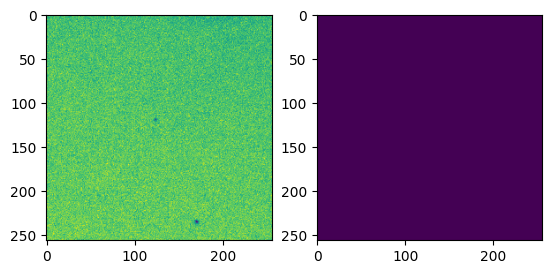

In [4]:
sample = train_generator.__next__()
fig, ax = plt.subplots(1, 2)
print(sample[0][0].shape)
ax[0].imshow(sample[0][0])
ax[1].imshow(sample[1][0])
plt.show()

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Function to calculate F1 score
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives + K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [6]:
# Input size
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 256, 256, 1
 
# Input layer
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = inputs 
 

# Contraction path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = Model(inputs=[inputs], outputs=[outputs])
     
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
 
# Display model summary
model.summary()

2025-01-16 13:38:05.432915: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-16 13:38:05.495120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13753 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:e1:00.0, compute capability: 8.6


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                            

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 

In [8]:
cb = EarlyStopping(
    monitor='val_f1',
    patience=15,
    restore_best_weights=True,
    mode='max'
    )

In [9]:
checkpoint_cb = ModelCheckpoint(
    filepath='model_checkpoint.h5',  # Path to save the model file
    monitor='val_f1',               # Metric to monitor
    verbose=1,                      # Verbosity level
    save_best_only=True,            # Save only the best model
    save_weights_only=False,        # Save the entire model (not just weights)
    mode='max',                     # 'max' since higher F1 is better
    save_freq='epoch'               # Save at the end of every epoch
)

In [10]:
with tf.device('/GPU:1'):    
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_image_generator),
        validation_data=val_generator,
        validation_steps=len(val_image_generator),
        epochs=45,
        callbacks=[cb],
        verbose=1
)

Epoch 1/45


2025-01-16 13:38:33.171262: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-16 13:38:33.833712: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-01-16 13:38:38.322567: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f291c5ad500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-16 13:38:38.322623: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-01-16 13:38:38.330346: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737034718.464536   11237 device_compiler.h:186] Compiled cluster using XLA!  This l

4176/4176 [==============================] - 573s 131ms/step - loss: 0.0647 - accuracy: 0.9870 - f1: 0.0078 - val_loss: 0.0257 - val_accuracy: 0.9962 - val_f1: 0.0000e+00
Epoch 2/45
4176/4176 [==============================] - 525s 126ms/step - loss: 0.0505 - accuracy: 0.9900 - f1: 0.4820 - val_loss: 0.0156 - val_accuracy: 0.9983 - val_f1: 0.7065
Epoch 3/45
4176/4176 [==============================] - 518s 124ms/step - loss: 0.0481 - accuracy: 0.9905 - f1: 0.5950 - val_loss: 0.0106 - val_accuracy: 0.9983 - val_f1: 0.7474
Epoch 4/45
4176/4176 [==============================] - 527s 126ms/step - loss: 0.0464 - accuracy: 0.9909 - f1: 0.6358 - val_loss: 0.0190 - val_accuracy: 0.9985 - val_f1: 0.7692
Epoch 5/45
4176/4176 [==============================] - 524s 126ms/step - loss: 0.0460 - accuracy: 0.9910 - f1: 0.6515 - val_loss: 0.0081 - val_accuracy: 0.9986 - val_f1: 0.7901
Epoch 6/45
4176/4176 [==============================] - 564s 135ms/step - loss: 0.0452 - accuracy: 0.9912 - f1: 0.665

In [11]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.008089649491012096
Best validation f1: 0.8274091482162476


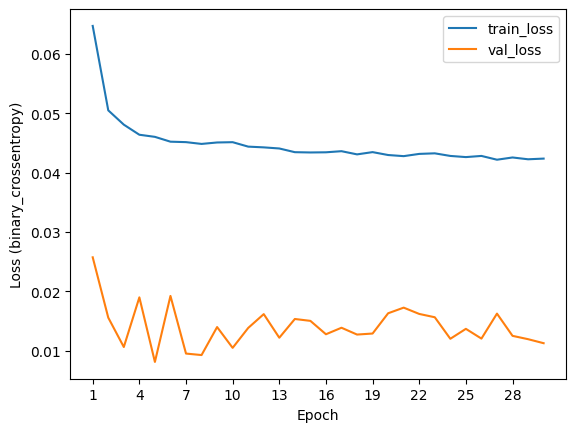

In [12]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1, len(loss) + 1)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

In [13]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
model_file_name = f'PetarPaskalev_232725_unet_model_4_256px_82F1.h5'
print(model_file_name)
model.save(model_file_name)

PetarPaskalev_232725_unet_model_4_256px_82F1.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
